-------FUNCTIONS------

Display Population on map

In [1]:
def display_population(pop):

    fig2 = plt.figure()
    bx = fig2.add_subplot(111)
    bx.imshow(environment, cmap='hot', interpolation='nearest')
    bx.scatter(start_point[0],start_point[1],marker="x", c="green")
    bx.scatter(goal_point[0],goal_point[1],marker="x", c="red")

    try:
        for individual in pop:

            individual.insert(0,start_point)

            individual_full=individual.copy()

            bx.plot(*zip(*individual_full))

        plt.show
    except:
        pass

Post-Processing (Attempt all permuations  : 2^(n-2))

In [2]:
def post_processing(initial_solution):

    permutations = get_permutations(initial_solution)

    fitnesses = []

    permutations.append(initial_solution)
    
    for individual in permutations:

        fitness=fitness_test(individual)

        fitnesses.append(fitness)

    max_index = fitnesses.index(max(fitnesses))

    max_fitness=fitnesses[max_index]
    final_solution=permutations[max_index]

    return max_fitness,final_solution

Extract gridcells along route: 2D

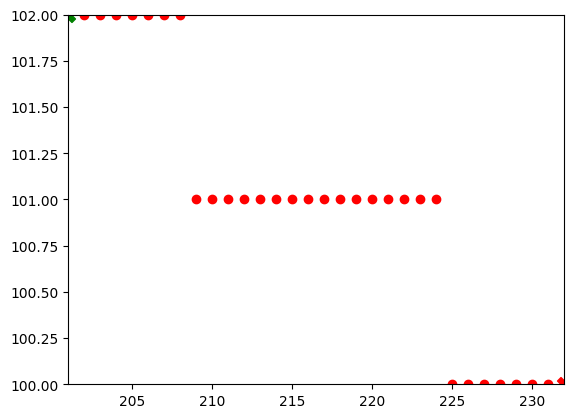

In [3]:
def bresenham_line(x1, y1, x2, y2):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1

    if dx > dy:
        err = dx / 2
        while x != x2:
            yield x, y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2
        while y != y2:
            yield x, y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    yield x, y

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

start=(201,102)
end=(232,100)

# Get the points on the line
points = list(bresenham_line(*start, *end))

# Print the list of points
# print(points)

# Create a plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the points on the line
ax.scatter([p[0] for p in points], [p[1] for p in points], c='r', marker='o')

# Plot the start and end points
ax.scatter(start[0], start[1], c='g', marker='X', s=100)
ax.scatter(end[0], end[1], c='r', marker='X', s=100)

# Set the limits for the axes
ax.set_xlim(min([p[0] for p in points]), max([p[0] for p in points]))
ax.set_ylim(min([p[1] for p in points]), max([p[1] for p in points]))

# Display the plot
plt.show()

Generate individual functions:
1. Random points
2. All points with LOS excluding goal point
3. All points with LOS including goal point (X second timeout)
4. Variable length individuals

In [4]:
def generate_individual(i,_):
    
    # Generate a random sequence of waypoints
    individual = []
    limit=GENE_LENGTH

    start=time.time()

    possible_points = np.argwhere(environment >= minimum_bs)

    while len(individual) < limit:
        index = random.choice(range(len(possible_points)))
        point = tuple(possible_points[index])
        possible_points = np.delete(possible_points, index, axis=0)
        y, x = point

        print(f"{i+1} / {POPULATION_SIZE} individuals generated: {round((time.time()-start),5)} Seconds elapsed", end='\r')

        if environment[y,x] >= minimum_bs:
            individual.append((x, y))

    return individual

In [5]:
def generate_individual_2(i,_):
    # Generate a random sequence of waypoints
    individual = []
    limit=GENE_LENGTH

    start=time.time()
    # print("\n")
    possible_points = np.argwhere(environment >= minimum_bs)

    while len(individual) < limit:
        index = random.choice(range(len(possible_points)))
        point = tuple(possible_points[index])
        possible_points = np.delete(possible_points, index, axis=0)
        y, x = point

        # print(f"{round((time.time()-start),5)} Seconds elapsed", end='\r')
        print(f"{i+1} / {POPULATION_SIZE} individuals generated: {round((time.time()-start),5)} Seconds elapsed", end='\r')

        if (time.time()-start)>100:
            return 0

        obstacles_hit=0

        if len(individual)==0:
            #Find all cells along line
            end_point=(x,y)

            cell_list=bresenham_line(*start_point,*end_point)

            for cell in cell_list:
                x,y=cell

                #if obstacle hit then flip flag
                if environment[y,x]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))
        else:
            end_point=(x,y)

            #Find all cells along line

            cell_list=bresenham_line(*individual[-1],*end_point)

            for cell in cell_list:
                x,y=cell

                #if obstacle hit then flip flag
                if environment[y,x]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))
        
    return individual

In [6]:
def generate_individual_3(i,timeout):
    # Generate a random sequence of waypoints
    individual = []
    limit=GENE_LENGTH

    start=time.time()
    # print("\n")

    possible_points = np.argwhere(environment >= minimum_bs)

    while len(individual) < limit:
        index = random.choice(range(len(possible_points)))
        point = tuple(possible_points[index])
        possible_points = np.delete(possible_points, index, axis=0)
        y, x = point

        # print(f"{round((time.time()-start),5)} Seconds elapsed", end='\r')
        print(f"{i+1} / {POPULATION_SIZE} individuals generated: {round((time.time()-start),5)} Seconds elapsed", end='\r')

        if (time.time()-start)>timeout:
            return 0

        obstacles_hit=0

        if len(individual)<minimum_bs:
            #Find all cells along line
            end_point=(x,y)

            cell_list=bresenham_line(*start_point,*end_point)

            cell_list=list(cell_list)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))
                
        elif len(individual)>0 and len(individual)<(limit-1):
            #Find all cells along line
            end_point=(x,y)

            #Find all cells along line
            cell_list=bresenham_line(*individual[-1],*end_point)
            cell_list=list(cell_list)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))

        elif len(individual)==limit-1:
            
            end_point=(x,y)

            #Find all cells along line
            cell_list1=bresenham_line(*individual[-1],*end_point)
            cell_list1=list(cell_list1)

            cell_list2=bresenham_line(*end_point,*goal_point)
            cell_list2=list(cell_list2)

            cell_list=cell_list1.copy()
            cell_list.extend(cell_list2)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))

            else:
                individual=[]
                
        
    return individual

In [7]:
def generate_individual_4(i,timeout):
    # Generate a random sequence of waypoints
    individual = []
    limit=GENE_LENGTH

    start=time.time()
    # print("\n")

    possible_points = np.argwhere(environment >= minimum_bs)

    while len(individual) < limit:
        index = random.choice(range(len(possible_points)))
        point = tuple(possible_points[index])
        possible_points = np.delete(possible_points, index, axis=0)
        y, x = point

        # print(f"{round((time.time()-start),5)} Seconds elapsed", end='\r')
        print(f"{i+1} / {POPULATION_SIZE} individuals generated: {round((time.time()-start),5)} Seconds elapsed", end='\r')

        if (time.time()-start)>timeout:
            return 0

        if len(individual)>0:
            cell_list=bresenham_line(*individual[-1],*goal_point)

            cell_list=list(cell_list)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                return individual

        obstacles_hit=0

        if len(individual)==0:
            #Find all cells along line
            end_point=(x,y)

            cell_list=bresenham_line(*start_point,*end_point)

            cell_list=list(cell_list)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))
                
        elif len(individual)>0 and len(individual)<(limit-1):

            #Find all cells along line
            end_point=(x,y)

            #Find all cells along line
            cell_list=bresenham_line(*individual[-1],*end_point)
            cell_list=list(cell_list)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))

        elif len(individual)==limit-1:
            
            end_point=(x,y)

            #Find all cells along line
            cell_list1=bresenham_line(*individual[-1],*end_point)
            cell_list1=list(cell_list1)

            cell_list2=bresenham_line(*end_point,*goal_point)
            cell_list2=list(cell_list2)

            cell_list=cell_list1.copy()
            cell_list.extend(cell_list2)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))

            else:
                individual=[]
                
        
    return individual


In [8]:
def generate_individual_5(i, timeout):

    # Generate a random sequence of waypoints
    individual = []
    limit = GENE_LENGTH

    start = time.time()

    possible_points = np.argwhere(environment >= minimum_bs)

    while len(individual) < limit:
        index = random.choice(range(len(possible_points)))
        point = tuple(possible_points[index])
        possible_points = np.delete(possible_points, index, axis=0)
        y, x = point

        print(f"{i+1} / {POPULATION_SIZE} individuals generated: {round((time.time()-start),5)} Seconds elapsed", end='\r')


        if (time.time() - start) > timeout:
            return 0

        if len(individual)>0:
            for goal in new_goal_points:
                cell_list=bresenham_line(*individual[-1],*goal)

                cell_list=list(cell_list)

                for cell in cell_list:
                    x1,y1=cell

                    #if obstacle hit then flip flag
                    if new_environment[y1,x1]<minimum_bs:
                        obstacles_hit=1

                if obstacles_hit==0:

                    return individual

        obstacles_hit = 0

        if len(individual)==0:
            #Find all cells along line
            end_point=(x,y)

            cell_list=bresenham_line(*new_start_point,*end_point)

            cell_list=list(cell_list)

            for cell in cell_list:
                x1,y1=cell

                #if obstacle hit then flip flag
                if new_environment[y1,x1]<minimum_bs:
                    obstacles_hit=1

            if obstacles_hit==0:

                individual.append((x, y))

        elif len(individual) > 0 and len(individual) < (limit - 1):

            # Find all cells along line
            end_point = (x, y)

            cell_list = bresenham_line(*individual[-1], *end_point)
            cell_list = list(cell_list)

            for cell in cell_list:
                x1, y1 = cell

                # if obstacle hit then flip flag
                if new_environment[y1, x1] < minimum_bs:
                    obstacles_hit = 1
                    break

            if not obstacles_hit:
                individual.append((x, y))

        elif len(individual) == limit - 1:

            end_point = (x, y)

            line_of_sight = False
            for goal in new_goal_points:
                cell_list1 = bresenham_line(*individual[-1], *end_point)
                cell_list1 = list(cell_list1)

                cell_list2 = bresenham_line(*end_point, *goal)
                cell_list2 = list(cell_list2)

                cell_list = cell_list1.copy()
                cell_list.extend(cell_list2)

                for cell in cell_list:
                    x1, y1 = cell

                    # if obstacle hit then flip flag
                    if new_environment[y1, x1] < minimum_bs:
                        obstacles_hit = 1
                        break

                if not obstacles_hit:
                    line_of_sight = True
                    break

            if line_of_sight:
                individual.append((x, y))

            else:
                individual = []

    return individual


Fitness function:
1. Obstacle Avoidance
2. Path Length
2. Average Altitude

In [9]:
def fitness_test(individual_full):
    
    # Calculate the path length
    path_length = 0
    # Calculate the number of obstacles hit
    obstacles_hit = 0

    cell_average_list=[]

    
    for i in range(len(individual_full) - 1):
        x1, y1 = individual_full[i]
        x2, y2 = individual_full[i+1]      

        if individual_full[i]!=individual_full[i+1]:

            path_length += np.sqrt((x2-x1)**2 + (y2-y1)**2)

            #Find all cells along line
            cell_list=list(bresenham_line(*individual_full[i],*individual_full[i+1]))

            cell_total=0

            for index,cell in enumerate(cell_list):
                x,y=cell

                # if y==200:
                #     print("")
                    
                #if obstacle hit then flip flag
                if environment[y,x]<minimum_bs:
                    obstacles_hit=1

                #add up cell values
                cell_total+=environment[y,x]

            # cell_list=list(cell_list)

            if len(cell_list)==0:
                print("")

            cell_average_list.append(cell_total/len(cell_list))
        
    individual_average=sum(cell_average_list)/len(cell_average_list)

    if obstacles_hit:
        fitness=0
    else:
        fitness=10000/path_length + 1*individual_average       

    return fitness


Selection Methods:
1. Roulette Wheel
2. Tournament
3. Stochastic Universal Sampling

In [10]:
def select_parents_rw(population, start_point, goal_point):
    # Perform roulette wheel selection

    global COUNTER

    fitnesses=[]
    usable_paths=[]
    usable_path_fitness=[]

    for individual in population:

        fitness=0
        
        individual_full=individual.copy()
        individual_full=concatenate(start_point,goal_point,individual_full)

        fitness=fitness_test(individual_full)
        fitnesses.append(fitness)

        if fitness>0:
            usable_paths.append([individual])
            usable_path_fitness.append(fitness)

        
    sum_fitness = sum(usable_path_fitness)
    probabilities = [fitness/sum_fitness for fitness in usable_path_fitness]
    parents = []
    for i in range(2):
        while True:

            try:
                index = np.random.choice(len(usable_path_fitness), p=probabilities)
            except ValueError as ve:
                # print(f'No viable paths for this configuration of parameters')
                # print(f"\n-----------------------------")

                # COUNTER+=1
                # print(f"\nDual Annealing attempt: {COUNTER}")
                return 0,0,0,0

            if usable_paths[index] not in parents:
                parents.append(usable_paths[index][0])
                break

    return parents, fitnesses, usable_path_fitness, usable_paths

In [11]:
def select_parents_tournament(population, start_point, goal_point, tournament_size=3):
    # Perform tournament selection
    import random

    global COUNTER

    fitnesses=[]
    usable_paths=[]
    usable_path_fitness=[]

    for individual in population:

        fitness=0
        
        individual_full=individual.copy()
        individual_full=concatenate(start_point,goal_point,individual_full)

        fitness=fitness_test(individual_full)
        fitnesses.append(fitness)

        if fitness>0:
            usable_paths.append([individual])
            usable_path_fitness.append(fitness)

    parents = []
    for i in range(2):
        tournament = random.choices(usable_paths, k=tournament_size)
        winner = max(tournament, key=lambda x: x[0])
        parents.append(winner[0])
        
    if not parents:
        print(f'No viable paths for this configuration of parameters')
        # print(f"\n-----------------------------")

        # COUNTER+=1
        # print(f"\nDual Annealing attempt: {COUNTER}")
        return 0,0,0,0
    
    return parents, fitnesses, usable_path_fitness, usable_paths


In [12]:
def select_parents_sus(population, start_point, goal_point, num_parents=10):
    # Perform Stochastic Universal Sampling (SUS)
    import random
    import numpy as np
    global COUNTER

    fitnesses=[]
    usable_paths=[]
    usable_path_fitness=[]

    for individual in population:

        fitness=0
        
        individual_full=individual.copy()
        individual_full=concatenate(start_point,goal_point,individual_full)

        fitness=fitness_test(individual_full)
        fitnesses.append(fitness)

        if fitness>0:
            usable_paths.append([individual])
            usable_path_fitness.append(fitness)

    parents = []
    if len(usable_paths) > 0:
        fitness_sum = sum(usable_path_fitness)
        spacing = fitness_sum / num_parents
        start = random.uniform(0, spacing)
        pointers = [start + i * spacing for i in range(num_parents)]
        idx = 0
        wheel = usable_path_fitness[idx]
        for pointer in pointers:
            while pointer > wheel:
                idx += 1
                wheel += usable_path_fitness[idx]
            parents.append(usable_paths[idx][0])
    else:
        print(f'No viable paths for this configuration of parameters')
        parents = [0,0]

    return parents, fitnesses, usable_path_fitness, usable_paths


-----SCRIPTS-------

Import libraries and map, Set start and end point

In [13]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from scipy.ndimage import binary_dilation
from scipy.ndimage import generate_binary_structure
import random
from IPython.display import clear_output
import os
import time
import copy
from ipynb.fs.full.shared_functions import crossover_sp, crossover_uniform, crossover_mp, get_permutations, concatenate ,mutate_random, mutate_swap, mutate_inversion,termination_check
import warnings

warnings.filterwarnings('ignore')
plt.close()

minimum_bs=5

# Load the data from the CSV file
environment = genfromtxt(r'C:\Users\ben\OneDrive - University of Bath\5th year\FYP\Simulation Development\Working Copies\MATLAB\MyWork\2D_results\NYC.csv', delimiter=',')

# # Flip the environment about the x-axis
# environment = np.fliplr(environment)
# environment = np.flipud(environment)

# Display environment before setting values less than 3 to 0
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].imshow(environment, cmap='hot', interpolation='nearest')
axes[0].set_title('Step 1')

# Set all values less than 3 to 0
environment[environment < minimum_bs] = 0
environment[environment > minimum_bs] = 10

# Display environment after setting values less than 3 to 0
axes[1].imshow(environment, cmap='hot', interpolation='nearest')
axes[1].set_title('Step 2')

padding_radius=1

# Pad all values equal to 0 with 0s in all directions by 5 units
struct = generate_binary_structure(2, 1)
dilated = binary_dilation((environment == 0), structure=struct, iterations=padding_radius)
environment[dilated] = 0


# Display environment after setting extra cells to 0 and padding 0s
axes[2].imshow(environment, cmap='hot', interpolation='nearest')
axes[2].set_title('Step 3')

# Show the figure with larger size
plt.figure(figsize=(10,10))
plt.imshow(environment, cmap='hot', interpolation='nearest')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Environment after setting extra cells to 0 and padding 0s (larger size)')

flag = 0

while not flag:
    x1, x2 = np.random.randint(low=0, high=environment.shape[1], size=2)
    y1, y2 = np.random.randint(low=0, high=environment.shape[0], size=2)
    start_point = (x1,y1)
    goal_point = (x2,y2)

    start_point = (230,65)
    goal_point = (1000,2420)

    if environment[y1,x1] != 0 and environment[y2,x2] != 0:
        flag = 1

cell_list = bresenham_line(*start_point,*goal_point)

plt.plot(*zip(*cell_list))

plt.scatter(start_point[0], start_point[1], marker="x", c="green")
plt.scatter(goal_point[0], goal_point[1], marker="x", c="blue")
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('NYC')

plt.show()


ModuleNotFoundError: No module named 'ipynb'

Display Population

Average length of individuals: 5.0


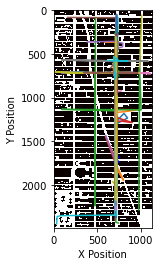

In [ ]:
POPULATION_SIZE=50
GENE_LENGTH=5
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.5
NUM_GENERATIONS = 100

timeout=1000

# Generate the initial population
population=[]

for i in range(POPULATION_SIZE):

    # population.append(generate_individual(i,timeout))

    population.append(generate_individual_2(i,_))

    # population.append(generate_individual_3(i,timeout))

    # population.append(generate_individual_4(i,timeout))

    if population[-1]==0:
        print(f"\nTime Limit reached")
        break


total_length = 0
for sublist in population:
    total_length += len(sublist)

avg_length = total_length / len(population)

clear_output()

print("Average length of individuals:", avg_length)

fig2 = plt.figure()
bx = fig2.add_subplot(111)
bx.imshow(environment, cmap='hot', interpolation='nearest')
bx.scatter(start_point[0],start_point[1],marker="x", c="green")
bx.scatter(goal_point[0],goal_point[1],marker="x", c="blue")
bx.set_xlabel('X Position')
bx.set_ylabel('Y Position')

try:
    for individual in population:

        individual.insert(0,start_point)

        individual_full=individual.copy()

        bx.plot(*zip(*individual_full))

    plt.show
except:
    pass


Main Script

In [ ]:
# Define the main function that runs the genetic algorithm
def main(Inputs):

    global POPULATION_SIZE,GENE_LENGTH,CROSSOVER_RATE,MUTATION_RATE,NUM_GENERATIONS,OPTIMAL_SOLUTION,OPTIMAL_FITNESS,COUNTER,average_fitness,best_fitnesses,global_best,BEST_FIRSTGEN
    POPULATION_SIZE,GENE_LENGTH,CROSSOVER_RATE,MUTATION_RATE,NUM_GENERATIONS=Inputs

    POPULATION_SIZE, GENE_LENGTH, NUM_GENERATIONS = map(round, (POPULATION_SIZE, GENE_LENGTH, NUM_GENERATIONS))

    clear_output()

    print(f"Attempt Number: {COUNTER} / {dual_annealing_iterations}")

    COUNTER+=1

    timeout=100

    # Generate the initial population
    print(f"Generating Population...")

    population=[]

    for i in range(POPULATION_SIZE):

        if population_method==1:
            population.append(generate_individual(i,timeout))
        elif population_method==2:
            population.append(generate_individual_2(i,timeout))
        elif population_method==3:
            population.append(generate_individual_3(i,timeout))
        elif population_method==4:
            population.append(generate_individual_4(i,timeout))
        elif population_method==5:
            population.append(generate_individual_5(i,timeout))


        if population[-1]==0:
            print(f"\nTime Limit reached")
            print(f"\n-----------------------------")

            return 1

    pop=copy.deepcopy(population)

    # display_population(pop)

    global_best=[]
    average_fitness=[]
    best_fitnesses = []  # initialize the list of best fitness values

    print(f"\nEvolving Population...")

    start=time.time()

    termination_flag=0
    generation=0

    while termination_flag == 0:

        generation += 1

        # Select parents
        parents, fitnesses, usable_path_fitness, usable_paths = select_parents_rw(population, start_point, goal_point)

        if parents == 0:
            return 1

        # Print the best individual in this generation
        best_fitness_index = usable_path_fitness.index(max(usable_path_fitness))

        best_individual = usable_paths[best_fitness_index][0]

        best_individual = concatenate(start_point, goal_point, best_individual)
        average_fitness.append((sum(fitnesses) / len(fitnesses))) # add the average fitness value to the list
        best_fitnesses.append(max(usable_path_fitness))  # add the maximum fitness value to the list

        if global_best==[]:
            global_best.append(usable_path_fitness[best_fitness_index])
            best_solution = best_individual
        elif usable_path_fitness[best_fitness_index] > global_best[-1]:
            global_best.append(usable_path_fitness[best_fitness_index])
            best_solution = best_individual
        else:
            global_best.append(global_best[-1])

        if generation==1:
            print("test")
            BEST_FIRSTGEN=best_individual
            
        print(f"Generation {generation}/{NUM_GENERATIONS}: Average Fitness =  {average_fitness[-1]}, Best Fitness = {global_best[-1]}", end='\r')

        # Create the next generation by crossover and mutation
        next_generation = []

        for i in range(0, POPULATION_SIZE, 2):

            parent1 = parents[0]
            parent2 = parents[1]
            child1, child2 = crossover_mp(parent1, parent2, CROSSOVER_RATE, GENE_LENGTH)
            child1 = mutate_inversion(child1, MUTATION_RATE, GENE_LENGTH, environment, dimensions=2)
            child2 = mutate_inversion(child2, MUTATION_RATE, GENE_LENGTH, environment, dimensions=2)
            next_generation.append(child1)
            next_generation.append(child2)

        # Replace the current population with the next generation
        population = next_generation

        current_time=round((time.time()-start),5)

        termination_flag=termination_check(generation,current_time,average_fitness,NUM_GENERATIONS, TIME_LIMIT_GA,STAGNATION_NUM,method='generations')


    if global_best[-1]>OPTIMAL_FITNESS:
        OPTIMAL_FITNESS=global_best[-1]
        OPTIMAL_SOLUTION=best_solution

    return 1/global_best[-1]
    

Run Main Script once

Attempt Number: 0 / 1
Generating Population...
1000 / 1000 individuals generated: 2.123 Seconds elapseded
Evolving Population...
test
Generation 50/50: Average Fitness =  8.974831788989427, Best Fitness = 13.2316107560377255
Best Result  =  13.231610756037725

Post Processing was beneficial: True


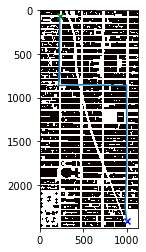

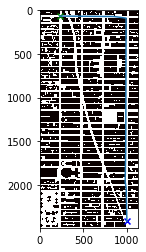

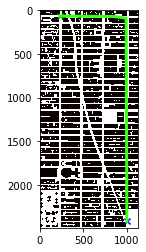

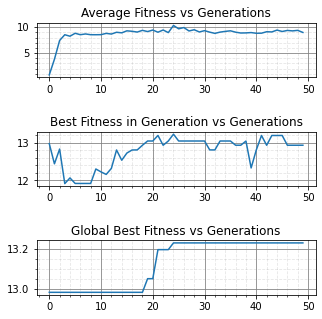

In [ ]:
POPULATION_SIZE=1000
GENE_LENGTH=10
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.5
NUM_GENERATIONS = 50

OPTIMAL_FITNESS=0
COUNTER=0
TIME_LIMIT_GA=5
STAGNATION_NUM=5
OPTIMAL_SOLUTION=[]

timeout=100
dual_annealing_iterations=1
population_method=2

Inputs=(POPULATION_SIZE,GENE_LENGTH,CROSSOVER_RATE,MUTATION_RATE,NUM_GENERATIONS)

result = main(Inputs)

if OPTIMAL_SOLUTION!=[]:

    print(f"\nBest Result  = ", 1/(result))

    max_fitness,final_solution = post_processing(OPTIMAL_SOLUTION)

    fig3 = plt.figure()

    fx=fig3.add_subplot(111)
    fx.imshow(environment, cmap='hot', interpolation='nearest')
    fx.scatter(start_point[0],start_point[1],marker="x", c="green")
    fx.scatter(goal_point[0],goal_point[1],marker="x", c="blue")
    fx.plot(*zip(*BEST_FIRSTGEN))

    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.imshow(environment, cmap='hot', interpolation='nearest')
    ax.scatter(start_point[0],start_point[1],marker="x", c="green")
    ax.scatter(goal_point[0],goal_point[1],marker="x", c="blue")
    ax.plot(*zip(*OPTIMAL_SOLUTION))

    fig2 = plt.figure()

    ex=fig2.add_subplot(111)
    ex.imshow(environment, cmap='hot', interpolation='nearest')
    ex.scatter(start_point[0],start_point[1],marker="x", c="green")
    ex.scatter(goal_point[0],goal_point[1],marker="x", c="blue")
    ex.plot(*zip(*final_solution), c='#39FF14', linewidth=3)
    # ex.plot(*zip(*final_solution))

    fig4 = plt.figure(figsize=(5, 5))

    # Add the first subplot for the average fitness values
    bx = fig4.add_subplot(311)
    bx.set_title('Average Fitness vs Generations')
    bx.plot(average_fitness)

    # Add the second subplot for the best fitness values
    cx = fig4.add_subplot(312)
    cx.set_title('Best Fitness in Generation vs Generations')
    cx.plot(best_fitnesses)

    # Add the third subplot for the global best fitness value
    dx = fig4.add_subplot(313)
    dx.set_title('Global Best Fitness vs Generations')
    dx.plot(global_best)

    bx.grid(b=True, which='major', color='grey', linestyle='-')
    cx.grid(b=True, which='major', color='grey', linestyle='-')
    dx.grid(b=True, which='major', color='grey', linestyle='-')

    bx.minorticks_on()
    bx.grid(b=True, which='minor', color='grey', linestyle='--', alpha=0.2)
    cx.minorticks_on()
    cx.grid(b=True, which='minor', color='grey', linestyle='--', alpha=0.2)
    dx.minorticks_on()
    dx.grid(b=True, which='minor', color='grey', linestyle='--', alpha=0.2)

    plt.subplots_adjust(hspace=1)

    print(f"\nPost Processing was beneficial: {len(OPTIMAL_SOLUTION)!=len(final_solution)}")

    plt.show()



Reactive Planning

In [ ]:
# # Assuming 'final_solution' is a list of (x, y) tuples
# x_values, y_values = zip(*OPTIMAL_SOLUTION)

# # Generate a random index between 1 and len(final_solution) - 2
# index = np.random.randint(1, len(OPTIMAL_SOLUTION) - 1)

# # Get the x and y coordinates of the randomly chosen point
# x_center, y_center = OPTIMAL_SOLUTION[index]

# # Set the radius of the circle to 5
# radius = 5

# # Create a new environment variable to avoid changing the existing one
# new_environment = environment.copy()

# # Create a meshgrid of x and y values
# xx, yy = np.meshgrid(np.arange(new_environment.shape[1]), np.arange(new_environment.shape[0]))

# # Create a mask for all points within the specified radius of the chosen point
# mask = ((xx - x_center)**2 + (yy - y_center)**2) <= radius**2

# # Set the values in the mask to 0
# new_environment[mask] = 0

# # Define the new start point as the point before the randomly selected one
# new_start_point = OPTIMAL_SOLUTION[index-1]

# # Define the new goal points as all points after the randomly selected one except for the one that was selected
# new_goal_points = OPTIMAL_SOLUTION[index+1:]

# population_method=5

# OPTIMAL_FITNESS=0

# result = main(Inputs)

# if OPTIMAL_SOLUTION!=[]:

#     max_fitness,final_solution2 = post_processing(OPTIMAL_SOLUTION)

#     fig = plt.figure()

#     cx = fig.add_subplot(111)
#     cx.imshow(new_environment, cmap='hot', interpolation='nearest')

#     cx.scatter(start_point[0],start_point[1],marker="x", c="green")
#     cx.scatter(goal_point[0],goal_point[1],marker="x", c="blue")

#     cx.scatter(new_start_point[0],new_start_point[1],marker="o", c="green")
#     for goal in new_goal_points:
#         cx.scatter(goal[0],goal[1],marker="o", c="blue")

#     cx.plot(*zip(*final_solution), color='blue')
#     cx.plot(*zip(*final_solution2), color='green')

#     print(f"\nPost Processing was beneficial: {len(OPTIMAL_SOLUTION)!=len(final_solution)}")

#     plt.show()


Dual Annealing

In [ ]:
# OPTIMAL_FITNESS=0
# COUNTER=0

# dual_annealing_iterations=5

# population_size_bounds=[10,100]
# gene_length_bounds=[2,10]
# crossover_rate_bounds=[0.6,0.9]
# muatation_rate_bounds=[0.01,0.5]
# num_generations_bounds=[50,100]

# bounds=[population_size_bounds,gene_length_bounds,crossover_rate_bounds,muatation_rate_bounds,num_generations_bounds]

# GA_params=dual_annealing(main,bounds,maxfun=dual_annealing_iterations)

# if OPTIMAL_SOLUTION!=[]:

#     clear_output()

#     max_fitness,final_solution = post_processing(OPTIMAL_SOLUTION)
#     print(f"\nPost Processing was beneficial: {len(OPTIMAL_SOLUTION)!=len(final_solution)}")

#     fig = plt.figure()
#     cx = fig.add_subplot(111)
#     cx.imshow(environment, cmap='hot', interpolation='nearest')
#     cx.scatter(start_point[0],start_point[1],marker="x", c="green")
#     cx.scatter(goal_point[0],goal_point[1],marker="x", c="blue")
#     cx.plot(*zip(*OPTIMAL_SOLUTION))
#     cx.plot(*zip(*final_solution))

#     print('Best Result  = ', 1/(GA_params.fun))
#     print('POPULATION_SIZE  = ', round(GA_params.x[0]),', GENE_LENGTH = ', round(GA_params.x[1]), ', CROSSOVER_RATE= ', GA_params.x[2], ', MUTATION_RATE = ', GA_params.x[3], ', NUM_GENERATIONS =', round(GA_params.x[4]))

#     plt.show()
